# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [2]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/Combine_Control_Tuesday-WorkingHours_training_80/result-lstm-tcp80-hl2-seq5-do0.2-oov1000-Friday-WorkingHours_testing_80.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Friday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')


In [3]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0
1,192.168.10.9-8694-172.217.10.238-80-tcp,0.044084,0,0,1,4392.532089,0,0,0
2,192.168.10.5-54842-172.82.206.1-80-tcp,0.021636,0,0,1,5296.533243,0,0,0
3,192.168.10.9-8843-52.84.143.147-80-tcp,0.032805,0,0,1,5979.860068,0,0,0
4,192.168.10.9-8820-72.21.91.29-80-tcp,0.033820,0,0,1,6178.973765,0,0,0


In [4]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


## Exploratory Data Analysis

In [5]:
df_truth[[' Label']].value_counts()

 Label  
BENIGN      414322
PortScan    158930
DDoS        128027
Bot           1966
Name: count, dtype: int64

In [6]:
df_pred[['b_iqr']].value_counts()

b_iqr
0        73273
Name: count, dtype: int64

In [7]:
df_pred[['b_zscore']].value_counts()

b_zscore
1           73174
0              99
Name: count, dtype: int64

In [8]:
df_truth.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [9]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 80
df_truth = df_truth[(df_truth['Source_Port'] == 80) | (df_truth['Destination_Port'] == 80)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220417 entries, 1 to 703236
Data columns (total 85 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow_ID                      220417 non-null  object 
 1   Source_IP                    220417 non-null  object 
 2   Source_Port                  220417 non-null  int64  
 3   Destination_IP               220417 non-null  object 
 4   Destination_Port             220417 non-null  int64  
 5   Protocol                     220417 non-null  int64  
 6   Timestamp                    220417 non-null  object 
 7   Flow_Duration                220417 non-null  int64  
 8   Total_Fwd_Packets            220417 non-null  int64  
 9   Total_Backward_Packets       220417 non-null  int64  
 10  Total_Length_of_Fwd_Packets  220417 non-null  int64  
 11  Total_Length_of_Bwd_Packets  220417 non-null  float64
 12  Fwd_Packet_Length_Max        220417 non-null  int64  
 13  Fwd_

In [10]:
df_truth['Label'].value_counts()

Label
DDoS        128027
BENIGN       92017
PortScan       373
Name: count, dtype: int64

In [11]:
df_truth['Label'].head()

1     BENIGN
2     BENIGN
14    BENIGN
26    BENIGN
39    BENIGN
Name: Label, dtype: object

In [12]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_362265/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [13]:
df_pred["id"]

0         192.168.10.5-54842-172.82.206.1-80-tcp
1        192.168.10.9-8694-172.217.10.238-80-tcp
2         192.168.10.5-54842-172.82.206.1-80-tcp
3         192.168.10.9-8843-52.84.143.147-80-tcp
4           192.168.10.9-8820-72.21.91.29-80-tcp
                          ...                   
73268    192.168.10.15-53989-23.52.155.27-80-tcp
73269    192.168.10.15-53993-23.52.155.27-80-tcp
73270    192.168.10.15-53994-23.52.155.27-80-tcp
73271    192.168.10.15-53990-23.52.155.27-80-tcp
73272     192.168.10.14-53233-72.21.91.29-80-tcp
Name: id, Length: 73273, dtype: object

In [14]:
df_truth["id"]

1           104.16.28.216-80-192.168.10.5-55054-tcp
2           104.16.28.216-80-192.168.10.5-55055-tcp
14         104.97.140.32-80-192.168.10.16-36206-tcp
26         151.101.0.249-80-192.168.10.16-43248-tcp
39        152.163.66.165-80-192.168.10.16-60350-tcp
                            ...                    
702971      192.168.10.15-53994-23.52.155.27-80-tcp
702975      192.168.10.15-53983-23.52.155.27-80-tcp
702979     63.144.176.10-80-192.168.10.14-53128-tcp
702981       72.21.91.29-80-192.168.10.14-53142-tcp
703236       192.168.10.14-53233-72.21.91.29-80-tcp
Name: id, Length: 220417, dtype: object

In [15]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [16]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [17]:
# df_pred[df_pred['Label'] == 1].to_csv('filtered_predictions-1-80-friday.csv', index=False)

df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
5782,172.16.0.1-49533-192.168.10.50-80-tcp,0.187500,0,0,1,131.909091,0,1,0,1
5783,172.16.0.1-49533-192.168.10.50-80-tcp,0.187500,0,0,1,131.909091,0,1,0,1
5784,172.16.0.1-49533-192.168.10.50-80-tcp,0.187500,0,0,1,131.909091,0,1,0,1
5785,172.16.0.1-49533-192.168.10.50-80-tcp,0.187500,0,0,1,131.909091,0,1,0,1
5786,172.16.0.1-49534-192.168.10.50-80-tcp,0.187500,0,0,1,131.909091,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
158227,172.16.0.1-54599-192.168.10.50-80-tcp,0.305556,0,0,0,12779.548387,0,0,0,1
158228,172.16.0.1-54599-192.168.10.50-80-tcp,0.305556,0,0,0,12779.548387,0,0,0,1
158229,172.16.0.1-54599-192.168.10.50-80-tcp,0.305556,0,0,0,12779.548387,0,0,0,1
184420,172.16.0.1-40504-192.168.10.50-80-tcp,0.064378,0,0,1,6274.491354,0,0,0,1


In [18]:
# df_pred[df_pred['Label'] == 0].to_csv('filtered_predictions-0-80-friday.csv', index=False)

df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
1,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
2,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
3,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
4,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
185686,192.168.10.15-53993-23.52.155.27-80-tcp,0.025761,0,0,1,3434.635071,0,0,0,0
185687,192.168.10.15-53994-23.52.155.27-80-tcp,0.025761,0,0,1,3434.635071,0,0,0,0
185688,192.168.10.15-53994-23.52.155.27-80-tcp,0.025761,0,0,1,3434.635071,0,0,0,0
185689,192.168.10.15-53990-23.52.155.27-80-tcp,0.025761,0,0,1,3434.635071,0,0,0,0


In [19]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
1,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
2,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
3,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
4,192.168.10.5-54842-172.82.206.1-80-tcp,0.021234,0,0,1,5442.276133,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
185686,192.168.10.15-53993-23.52.155.27-80-tcp,0.025761,0,0,1,3434.635071,0,0,0,0
185687,192.168.10.15-53994-23.52.155.27-80-tcp,0.025761,0,0,1,3434.635071,0,0,0,0
185688,192.168.10.15-53994-23.52.155.27-80-tcp,0.025761,0,0,1,3434.635071,0,0,0,0
185689,192.168.10.15-53990-23.52.155.27-80-tcp,0.025761,0,0,1,3434.635071,0,0,0,0


In [20]:
df_pred[['Label']].value_counts()

Label
1        128654
0         57037
Name: count, dtype: int64

In [21]:
import os
# Define the directory path
dir_path = '../mcnemar/http'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [22]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [23]:
df_pred[['b_zscore']]

,b_zscore
0,1
1,1
2,1
3,1
4,1
...,...
185686,1
185687,1
185688,1
185689,1


### Detection Rate

In [24]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i].astype(int))
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i].astype(int))
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.0
Recall-Binary-b_iqr: 0.0
Recall-Binary-b_zscore: 0.9964012001181464
Recall-Floating-f_mean: 0.0
Recall-Floating-f_iqr: 0.9987252631088035
Recall-Floating-f_zscore: 0.0


### Confussion Matrix

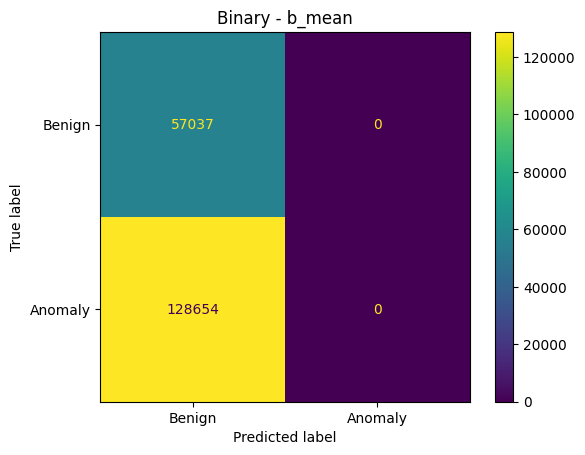

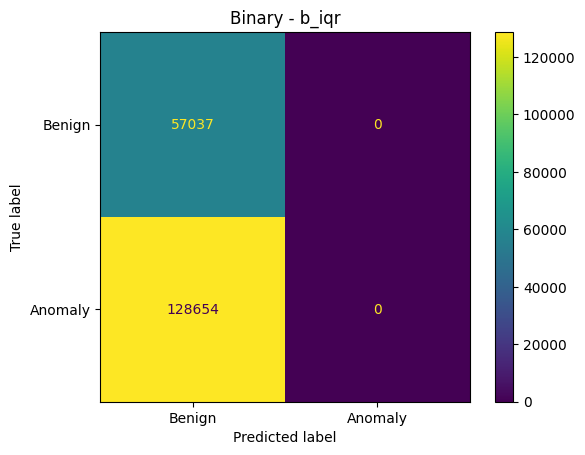

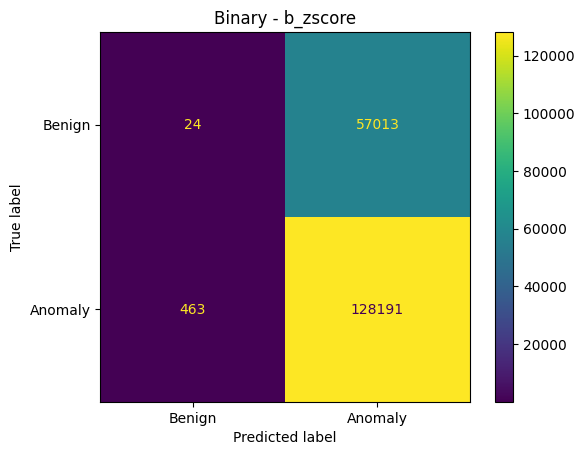

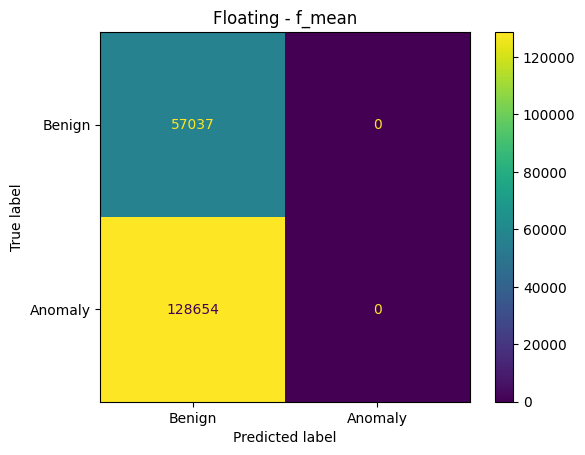

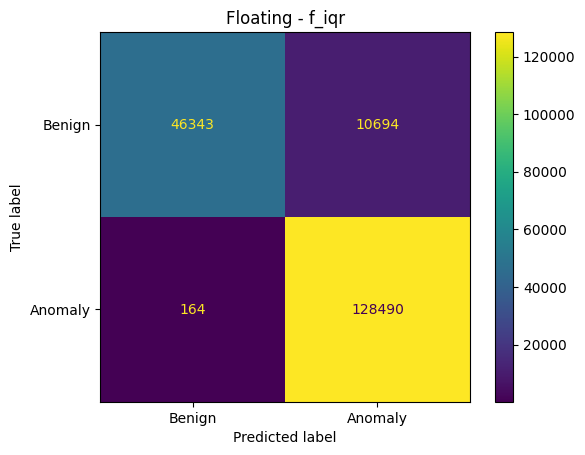

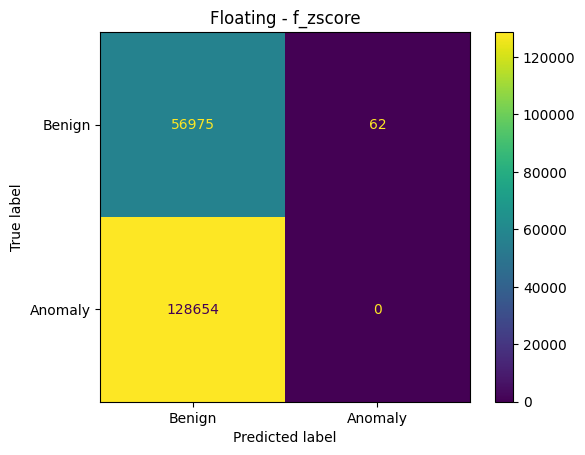

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i].astype(int))
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i].astype(int))
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [26]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.0
F2-Binary-b_iqr: 0.0
F2-Binary-b_zscore: 0.9158855134177359
F2-Floating-f_mean: 0.0
F2-Floating-f_iqr: 0.9826399510553686
F2-Floating-f_zscore: 0.0


### FPR Score

In [27]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i].astype(int)).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 0.0
FPR-Binary-b_iqr: 0.0
FPR-Binary-b_zscore: 0.9995792205059874
FPR-Floating-f_mean: 0.0
FPR-Floating-f_iqr: 0.18749232954047373
FPR-Floating-f_zscore: 0.0010870136928660342


In [28]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i].astype(int))
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i].astype(int))
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.3071608209337017
Accuracy-Binary-b_iqr: 0.3071608209337017
Accuracy-Binary-b_zscore: 0.6904750364853439
Accuracy-Floating-f_mean: 0.3071608209337017
Accuracy-Floating-f_iqr: 0.9415265144783538
Accuracy-Floating-f_zscore: 0.3068269329154348


In [29]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.000000,0.000000,0.000000,0.307161
b_iqr,0.000000,0.000000,0.000000,0.307161
b_zscore,0.996401,0.915886,0.999579,0.690475
f_mean,0.000000,0.000000,0.000000,0.307161
f_iqr,0.998725,0.982640,0.187492,0.941527
f_zscore,0.000000,0.000000,0.001087,0.306827


In [30]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [31]:
# %pip install openpyxl